In [1]:
# Consider recent scenes over Mt Rainier

%load_ext watermark

# Use earthaccess instead of asf_search
#import asf_search as asf
import earthaccess
import geopandas as gpd
import pandas as pd
import os
import xarray as xr
import numpy as np
import datatree
import fsspec
import dask

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%watermark --iversions

pandas     : 2.0.3
numpy      : 1.25.1
earthaccess: 0.7.1
xarray     : 2023.11.0
fsspec     : 2023.10.0
datatree   : 0.0.13
IPython    : 8.14.0
matplotlib : 3.7.2
dask       : 2023.11.0
geopandas  : 0.13.2



In [2]:
results = earthaccess.search_data(
    short_name='OPERA_L2_CSLC-S1_V1',
    cloud_hosted=True,
    point=(-121.744564, 46.796787),
    #temporal=("1999-02", "2019-03"),
    #count=5
    #OPERA_BURST_ID='T013_026571_IW1' #unknown key.. not implemented? https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-additional-attribute
)

Granules found: 12


In [3]:
# ? How to get these into a GeoDataFrame, ASF search makes this easier...
BURST = 'T013_026571_IW1'

filtered_results = []
for r in results:
    
    for x in r['umm']['AdditionalAttributes']:
        if x['Name']=='OPERA_BURST_ID':
            burst_id = x['Values'][0] 
    
    if burst_id == BURST:
        filtered_results.append(r)

In [4]:
len(filtered_results)

4

In [5]:
data_links = [granule.data_links(access="direct")[0] for granule in filtered_results]
url = data_links[0]
url

's3://asf-cumulus-prod-opera-products/OPERA_L2_CSLC-S1/OPERA_L2_CSLC-S1_T013-026571-IW1_20231007T142223Z_20231009T193106Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T013-026571-IW1_20231007T142223Z_20231009T193106Z_S1A_VV_v1.0.h5'

In [6]:
#fss3 = earthaccess.get_s3fs_session(daac='ASF') #Only for Sentinel-1 bucket 

#Instead use https://cumulus.asf.alaska.edu/s3credentials (good for 1 hour)
fss3 = earthaccess.get_s3fs_session(results=filtered_results)

In [7]:
# Customize FSSPEC URL handling (pre-download entire file to /tmp directory when accessed)
fileobj = fsspec.open('filecache::'+url,
             s3=fss3.storage_options,
             same_names=True,
             filecache={'cache_storage':'/tmp/files'}).open()

In [8]:
path = fileobj
dt = datatree.open_datatree(path, phony_dims='sort') # not sure why phony_dims is necessary...

# interactively explore full HDF
#dt 

In [9]:
ds = xr.open_dataset(fileobj,
                     group='data',
                     engine='h5netcdf').rename(dict(x_coordinates='x', y_coordinates='y'))

# To get datetime of acquistion
print(pd.to_datetime(xr.open_dataset(fileobj, group='identification')['zero_doppler_start_time'].data.astype('U')))

da = ds.VV
da

2023-10-07 14:22:23.125602


<xarray.DataArray 'VV' (y: 4710, x: 19866)>
[93568860 values with dtype=complex64]
Coordinates:
  * x        (x) float64 5.314e+05 5.314e+05 5.314e+05 ... 6.307e+05 6.307e+05
  * y        (y) float64 5.204e+06 5.204e+06 5.204e+06 ... 5.157e+06 5.157e+06
Attributes:
    description:   VV geocoded CSLC image
    grid_mapping:  projection

In [10]:
# # tiny chunks, so will not stream well unless reader knows how to do range requests...
da.encoding

{'chunksizes': (128, 128),
 'fletcher32': False,
 'shuffle': True,
 'preferred_chunks': {'y_coordinates': 128, 'x_coordinates': 128},
 'zlib': True,
 'complevel': 4,
 'source': "<_io.BufferedReader name='/tmp/files/OPERA_L2_CSLC-S1_T013-026571-IW1_20231007T142223Z_20231009T193106Z_S1A_VV_v1.0.h5'>",
 'original_shape': (4710, 19866),
 'dtype': dtype('complex64')}

In [11]:
data_links

['s3://asf-cumulus-prod-opera-products/OPERA_L2_CSLC-S1/OPERA_L2_CSLC-S1_T013-026571-IW1_20231007T142223Z_20231009T193106Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T013-026571-IW1_20231007T142223Z_20231009T193106Z_S1A_VV_v1.0.h5',
 's3://asf-cumulus-prod-opera-products/OPERA_L2_CSLC-S1/OPERA_L2_CSLC-S1_T013-026571-IW1_20231019T142223Z_20231020T143839Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T013-026571-IW1_20231019T142223Z_20231020T143839Z_S1A_VV_v1.0.h5',
 's3://asf-cumulus-prod-opera-products/OPERA_L2_CSLC-S1/OPERA_L2_CSLC-S1_T013-026571-IW1_20231112T142222Z_20231113T092554Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T013-026571-IW1_20231112T142222Z_20231113T092554Z_S1A_VV_v1.0.h5',
 's3://asf-cumulus-prod-opera-products/OPERA_L2_CSLC-S1/OPERA_L2_CSLC-S1_T013-026571-IW1_20231112T142222Z_20231113T122405Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T013-026571-IW1_20231112T142222Z_20231113T122405Z_S1A_VV_v1.0.h5']

In [12]:
%%time

# NOte: this will pre-download

@dask.delayed
def custom_open(url):
     return fsspec.open('filecache::'+url,
             s3=fss3.storage_options,
             same_names=True,
             filecache={'cache_storage':'/tmp/files'}).open()
    
fileobjs = dask.compute(*[custom_open(url) for url in data_links])

CPU times: user 246 ms, sys: 35.2 ms, total: 281 ms
Wall time: 275 ms


In [13]:
path = fileobjs[0]
dsR = xr.open_dataset(path,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))


tR = pd.to_datetime(xr.open_dataset(path, group='identification')['zero_doppler_start_time'].data.astype('U'))
print(tR)
                    
dsR

2023-10-07 14:22:23.125602


<xarray.DataArray 'VV' (y: 4710, x: 19866)>
[93568860 values with dtype=complex64]
Coordinates:
  * x        (x) float64 5.314e+05 5.314e+05 5.314e+05 ... 6.307e+05 6.307e+05
  * y        (y) float64 5.204e+06 5.204e+06 5.204e+06 ... 5.157e+06 5.157e+06
Attributes:
    description:   VV geocoded CSLC image
    grid_mapping:  projection

In [14]:
path = fileobjs[-1]
dsS = xr.open_dataset(path,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))

tS = pd.to_datetime(xr.open_dataset(path, group='identification')['zero_doppler_start_time'].data.astype('U'))
print(tS)

dsS

2023-11-12 14:22:22.705686


<xarray.DataArray 'VV' (y: 4710, x: 19866)>
[93568860 values with dtype=complex64]
Coordinates:
  * x        (x) float64 5.314e+05 5.314e+05 5.314e+05 ... 6.307e+05 6.307e+05
  * y        (y) float64 5.204e+06 5.204e+06 5.204e+06 ... 5.157e+06 5.157e+06
Attributes:
    description:   VV geocoded CSLC image
    grid_mapping:  projection

In [15]:
# Plot amplitude and phase
ifg = dsR * np.conj(dsS)
ifg.attrs['reference'] = tR
ifg.attrs['secondary'] = tS
ifg

<xarray.DataArray 'VV' (y: 4710, x: 19866)>
array([[nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       ...,
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj]],
      dtype=complex64)
Coordinates:
  * x        (x) float64 5.314e+05 5.314e+05 5.314e+05 ... 6.307e+05 6.307e+05
  * y        (y) float64 5.204e+06 5.204e+06 5.204e+06 ... 5.157e+06 5.157e+06
Attributes:
    reference:  2023-10-07 14:22:23.125602
    secondary:  2023-11-12 14:22:22.705686

In [16]:
da = xr.apply_ufunc(np.angle, ifg)
ds = da.to_dataset(name='phase')
ds

<xarray.Dataset>
Dimensions:  (x: 19866, y: 4710)
Coordinates:
  * x        (x) float64 5.314e+05 5.314e+05 5.314e+05 ... 6.307e+05 6.307e+05
  * y        (y) float64 5.204e+06 5.204e+06 5.204e+06 ... 5.157e+06 5.157e+06
Data variables:
    phase    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

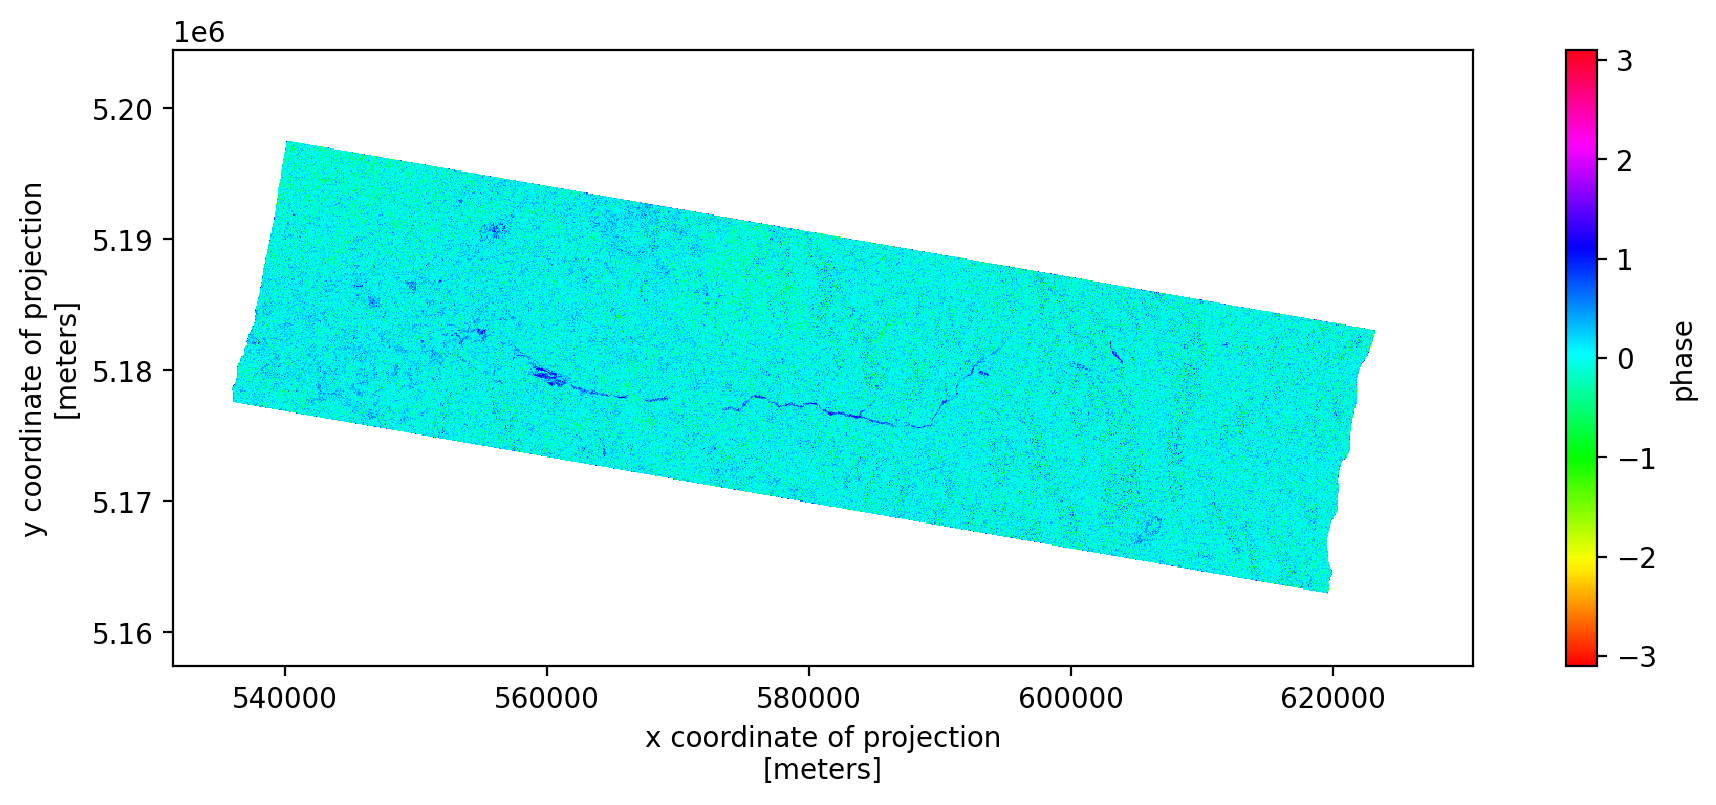

In [17]:
# 80meter posting for faster plots
nx=16
ny=8 

fig,ax = plt.subplots(figsize=(12,4))
ds.phase.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=ax) #20m posting
plt.gca().set_aspect('equal')

In [18]:
def scale_amplitude(da):
    ''' decible scale for viz'''
    return 20*np.log10(np.abs(da))

ds['amplitude'] = xr.apply_ufunc(scale_amplitude, ifg)
ds

<xarray.Dataset>
Dimensions:    (x: 19866, y: 4710)
Coordinates:
  * x          (x) float64 5.314e+05 5.314e+05 5.314e+05 ... 6.307e+05 6.307e+05
  * y          (y) float64 5.204e+06 5.204e+06 5.204e+06 ... 5.157e+06 5.157e+06
Data variables:
    phase      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    amplitude  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

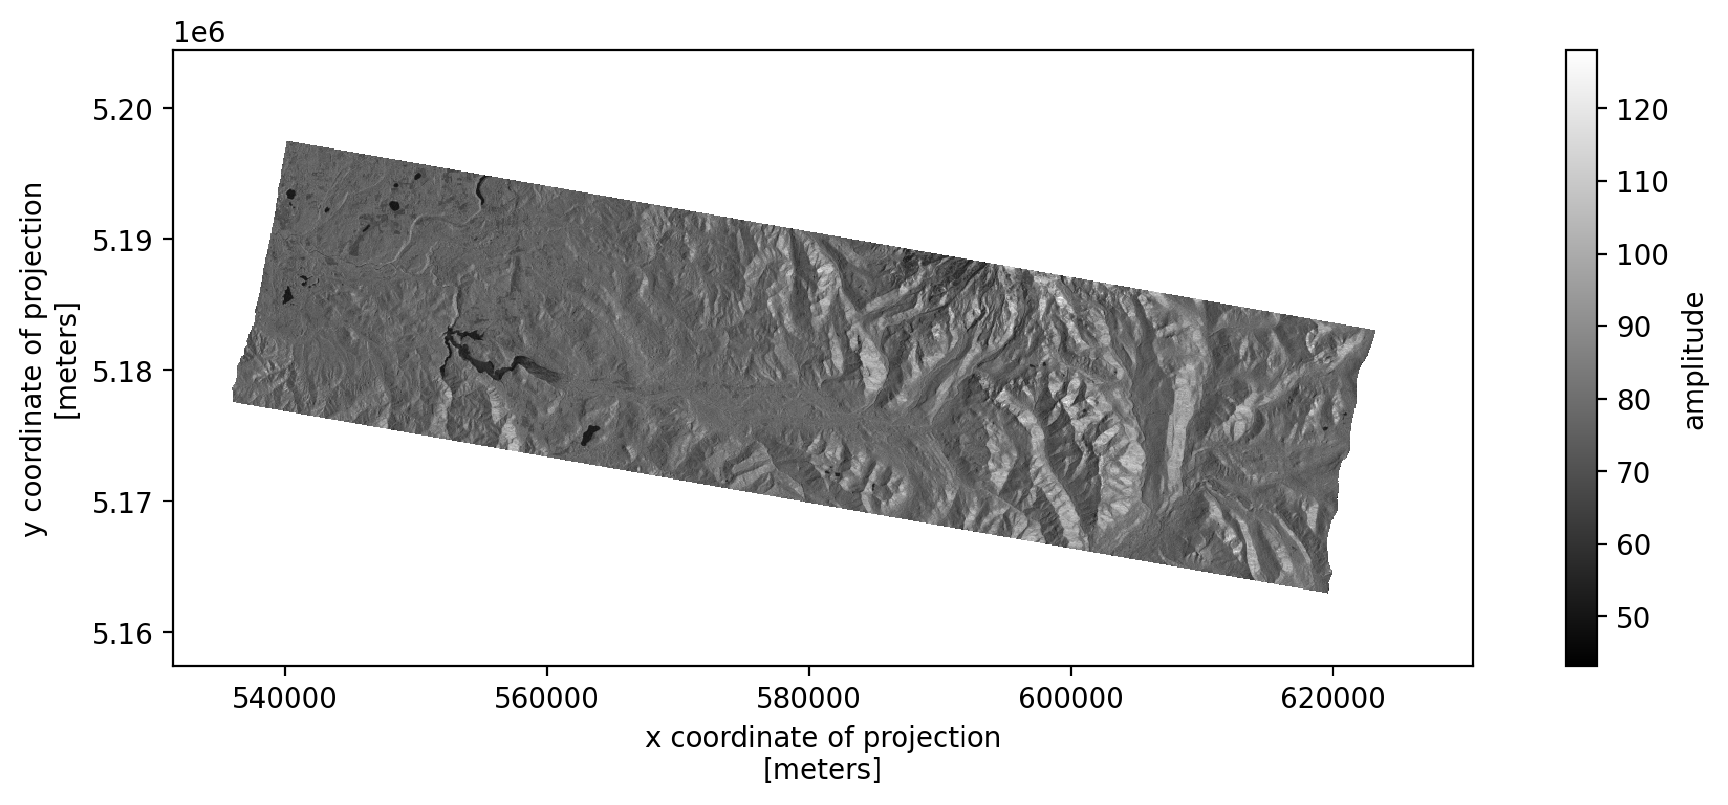

In [19]:
fig,ax = plt.subplots(figsize=(12,4))
ds.amplitude.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='gray', ax=ax) #20m posting
plt.gca().set_aspect('equal')